In [21]:
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='ee-thesiswar')

### Sources 
- https://github.com/dtiede/obia_tutorials_DT
- https://github.com/fkroeber/obia_tutorials
- https://github.com/candepelliza/OBIA_Python
### report
- https://docs.google.com/document/d/1YxABZxQ42aIqVjZ9wC0jDVbd5bE2ynyNG8E6hK99sig/edit?usp=sharing 


In [82]:
aoi_coords = [ 
	[ 
		[14.014975681960243, 50.495054834163], 
		[14.014975681960243, 50.68388414362033], 
		[14.316010224669142, 50.68388414362033], 
		[14.316010224669142, 50.495054834163], 
		[14.014975681960243, 50.495054834163] 
	] 
]
aoi = ee.Geometry.Polygon(aoi_coords)

In [86]:

def collect_sentinel_image(aoi, start_date, end_date, cloud_threshold=20):
    """Collects the least cloudy Sentinel-2 image within the AOI and date range."""
    collection = (
        ee.ImageCollection("COPERNICUS/S2")
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_threshold))
        .sort("CLOUDY_PIXEL_PERCENTAGE")
    )
    image = collection.first().clip(aoi)
    return image
sentinel_image = collect_sentinel_image(aoi, "2024-06-01", "2024-08-31")



Generating URL ...
An error occurred while downloading.
Total request size (206071875 bytes) must be less than or equal to 50331648 bytes.


In [6]:
def compute_indices(image):
    """Computes NDVI, NDWI, NDBI, and EBBI indices and adds them as bands."""
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")  # (NIR - Red) / (NIR + Red)
    ndwi = image.normalizedDifference(["B3", "B8"]).rename("NDWI")  # (Green - NIR) / (Green + NIR)
    ndbi = image.normalizedDifference(["B11", "B8"]).rename("NDBI")  # (SWIR - NIR) / (SWIR + NIR)
    ebbi = ndbi.subtract(ndvi).rename("EBBI")  # EBBI = NDBI - NDVI
    
    # Select relevant bands and add the computed indices
    image = image.select(["B8", "B4", "B3", "B2", "B11"]).addBands([ndvi, ndwi, ndbi, ebbi]).rename(
        ["NIR", "Red", "Green", "Blue", "SWIR", "NDVI", "NDWI", "NDBI", "EBBI"]
    )
    return image

image_9band = compute_indices(sentinel_image)

In [24]:
def compute_glcm_metrics(image, window_size=4):
    """Computes Prominence, Sum Variance, Dissimilarity, and Entropy GLCM metrics."""
    # Select the NIR band (already renamed to 'NIR' in compute_indices)
    nir = image.select('NIR')
    
    # Ensure the NIR band is integer-valued.
    # Sentinel-2 bands are scaled by 10,000 in GEE, so we rescale to 0-255 for 8-bit representation.
    nir_rescaled = nir.divide(10000).multiply(255).int()
    
    # Compute GLCM texture metrics on the rescaled NIR band.
    glcm = nir_rescaled.glcmTexture()
    
    # Select the required GLCM metrics
    # Note: The actual band names are prefixed with 'NIR_', not 'B8_'
    # Prominence, Sum Variance, Dissimilarity, and Entropy
    glcm_selected = glcm.select(['NIR_prom', 'NIR_svar', 'NIR_diss', 'NIR_ent'])
    
    # Rename bands for clarity and consistency
    glcm_selected = glcm_selected.rename(['Prominence', 'Sum_Variance', 'Dissimilarity', 'Entropy'])
    
    return glcm_selected

glcm_metrics = compute_glcm_metrics(image_9band, window_size=4)


In [145]:

seed = ee.Algorithms.Image.Segmentation.seedGrid(30)
def perform_snic(image, size=10, compactness=0.1, connectivity=4):
    """Performs SNIC segmentation on the input image using spectral indices only."""
    print("Performing SNIC segmentation...")
    # Select bands to be used for segmentation (excluding GLCM metrics)
    segmentation_bands = image.select([
        "NIR", "Red", "Green", "Blue", "SWIR",
        "NDVI", "NDWI", "NDBI", "EBBI"
    ])
    
    snic = ee.Algorithms.Image.Segmentation.SNIC(
        image=segmentation_bands,
        size=size,
        compactness=compactness,
        connectivity=connectivity,
        seeds=seed
    )
    
    print("Selecting 'clusters' and mean bands...")
    # Select 'clusters' and mean bands
    input_band_names = segmentation_bands.bandNames().getInfo()
    mean_band_names = [band + "_mean" for band in input_band_names]
    snic_selected = snic.select(["clusters"] + mean_band_names, ["clusters"] + input_band_names)
    
    # Cast 'clusters' to integer and ensure it's the first band
    clusters = snic_selected.select("clusters").toInt()
    snic_final = clusters.addBands(snic_selected.select([
        "NIR", "Red", "Green", "Blue", "SWIR",
        "NDVI", "NDWI", "NDBI", "EBBI"
    ]))
    
    print("SNIC band names:", snic_final.bandNames().getInfo())
    
    # Print clusters min and max
    clusters_min_max = snic_final.select("clusters").reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=aoi,
        scale=10,
        maxPixels=1e13
    ).getInfo()
    print("Clusters min and max:", clusters_min_max)
    
    print("SNIC segmentation completed successfully.")
    return snic_final
def snic_to_polygons(snic, aoi, scale=10):
    polygons = snic.reduceToVectors(
        geometry=aoi,
        geometryType="polygon",
        eightConnected=True,
        labelProperty="clusters",
        reducer=ee.Reducer.first(),
        scale=scale,
        maxPixels=1e13
    )
    polygon_count = polygons.size().getInfo()
    print("Number of polygons:", polygon_count)
    return polygons

# Perform SNIC segmentation with integrated GLCM metrics
snic = perform_snic(image_9band)
polygons = snic_to_polygons(snic, aoi)
# Define visualization parameters



Performing SNIC segmentation...
Selecting 'clusters' and mean bands...
SNIC band names: ['clusters', 'NIR', 'Red', 'Green', 'Blue', 'SWIR', 'NDVI', 'NDWI', 'NDBI', 'EBBI']
Clusters min and max: {'clusters_max': 2147472577, 'clusters_min': -2147362499}
SNIC segmentation completed successfully.
Number of polygons: 5067


In [144]:
m = geemap.Map()
m.setCenter(14.16643443774737, 50.53838832023237, 13)
m.addLayer(aoi, {}, "AOI")
m.addLayer(sentinel_image, {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}, "Sentinel-2")
m.addLayer(polygons, {}, "Polygons")

m

Map(center=[50.53838832023237, 14.16643443774737], controls=(WidgetControl(options=['position', 'transparent_b…

In [128]:
def compute_mean_glcm_metrics(polygons, glcm_metrics, scale=10):
    """Computes mean of Prominence, Sum Variance, Dissimilarity, and Entropy per polygon."""
    print("Computing mean GLCM metrics for each polygon...")
    # Add the four GLCM metrics to the polygons as properties
    polygons_with_metrics = polygons.map(lambda feature: feature.set({
        "Prominence_mean": glcm_metrics.select("Prominence").reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=scale,
            bestEffort=True
        ).get("Prominence"),
        "Sum_Variance_mean": glcm_metrics.select("Sum_Variance").reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=scale,
            bestEffort=True
        ).get("Sum_Variance"),
        "Dissimilarity_mean": glcm_metrics.select("Dissimilarity").reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=scale,
            bestEffort=True
        ).get("Dissimilarity"),
        "Entropy_mean": glcm_metrics.select("Entropy").reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=scale,
            bestEffort=True
        ).get("Entropy")
    }))
    
    print("Mean GLCM metrics computed for all polygons.")
    return polygons_with_metrics

polygons_with_glcm = compute_mean_glcm_metrics(polygons, glcm_metrics, scale=10)


Computing mean GLCM metrics for each polygon...
Mean GLCM metrics computed for all polygons.


In [129]:
def classify_polygon(feature):
    """Applies classification rules to each polygon based on cluster's mean band values and GLCM metrics."""
    # Extract mean band values directly from the cluster
    nir_val = ee.Number(feature.get("NIR"))
    red_val = ee.Number(feature.get("Red"))
    green_val = ee.Number(feature.get("Green"))
    blue_val = ee.Number(feature.get("Blue"))
    swir_val = ee.Number(feature.get("SWIR"))
    ndvi_val = ee.Number(feature.get("NDVI"))
    ndwi_val = ee.Number(feature.get("NDWI"))
    ndbi_val = ee.Number(feature.get("NDBI"))
    ebbi_val = ee.Number(feature.get("EBBI"))
    prominence_val = ee.Number(feature.get("Prominence_mean"))
    sum_var_val = ee.Number(feature.get("Sum_Variance_mean"))
    dissim_val = ee.Number(feature.get("Dissimilarity_mean"))
    entropy_val = ee.Number(feature.get("Entropy_mean"))
    
    # Initialize classification with a default "Unclassified" state
    assigned_class = ee.String("Unclassified")
    class_code = ee.Number(0)  # 0 for 'Unclassified'
    
    # Classification Rules:
    # 1. Water: NDWI > 0.0 & NDVI < 0.2 & High Dissimilarity
    is_water = ndwi_val.gt(0.0).And(ndvi_val.lt(0.2))
    assigned_class = ee.String(ee.Algorithms.If(is_water, "Water", assigned_class))
    class_code = ee.Number(ee.Algorithms.If(is_water, 5, class_code))

    # 2. Forest/vegetation: NDVI > 0.44 & EBBI < -0.5
    is_forest = ndvi_val.gt(0.4).And(ebbi_val.lt(-0.5))
    assigned_class = ee.String(ee.Algorithms.If(is_forest, "Forest", assigned_class))
    class_code = ee.Number(ee.Algorithms.If(is_forest, 1, class_code))

    # 3. Field: 0.2 < NDVI < 0.44 & Moderate Dissimilarity
    is_field = ndvi_val.gt(0.1).And(ndvi_val.lt(0.44)).And(dissim_val.lt(6))
    assigned_class = ee.String(ee.Algorithms.If(is_field, "Field", assigned_class))
    class_code = ee.Number(ee.Algorithms.If(is_field, 2, class_code))

    # 4. Builtup: NDVI < 0.2 & NDWI < 0.0 & High Dissimilarity
    is_builtup = ndvi_val.lt(0.4).And(ndwi_val.lt(0.0)).And(dissim_val.gt(6))
    assigned_class = ee.String(ee.Algorithms.If(is_builtup, "Builtup", assigned_class))
    class_code = ee.Number(ee.Algorithms.If(is_builtup, 3, class_code))
    
    return feature.set({
        "class": assigned_class,
        "class_code": class_code
    })

print("Classifying polygons based on spectral indices and GLCM metrics...")
classified_polygons = polygons_with_glcm.map(classify_polygon)
classified_polygons_count = classified_polygons.size().getInfo()
print(f"Number of classified polygons: {classified_polygons_count}")




Classifying polygons based on spectral indices and GLCM metrics...
Number of classified polygons: 44799


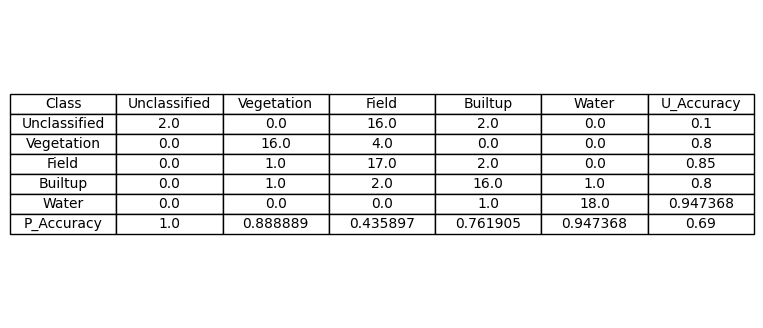

In [69]:

import pandas as pd
import numpy as np
from IPython.display import Image


# 1) Define data (no totals, no Kappa). 
#    Here rows 0..4 are classes, row 5 is Producer Accuracy ("P_Accuracy").
data = [
    ["Unclassified",        2,   0,   16,   2,   0,   0.10     ],
    ["Vegetation",        0,  16,    4,   0,   0,   0.80     ],
    ["Field",        0,   1,   17,   2,   0,   0.85     ],
    ["Builtup",        0,   1,    2,  16,   1,   0.80     ],
    ["Water",        0,   0,    0,   1,  18,   0.947368 ],
    ["P_Accuracy", 1.000, 0.888889, 0.435897, 0.761905, 0.947368, 0.69],
]

# Columns: "ClassValue", plus one for each predicted class, plus "U_Accuracy"
columns = ["Class","Unclassified" ,"Vegetation", "Field", "Builtup", "Water","U_Accuracy"]
df = pd.DataFrame(data, columns=columns)

# 2) Custom formatting function:
#    - Show no decimals if the value is an integer (e.g. "2" not "2.00")
#    - Otherwise show two decimals (e.g. "0.85" becomes "0.85")
#    - Display empty string if value is None/NaN
def custom_format(x):
    if pd.isnull(x):
        return ""  # Hide None in P_Accuracy's U_Accuracy cell
    try:
        # Convert to float, then decide how to format
        val = float(x)
        if val.is_integer():
            return str(int(val))         # e.g. 2.0 -> "2"
        else:
            return f"{val:.2f}"         # e.g. 0.1234 -> "0.12"
    except ValueError:
        return str(x)  # If it's something else (like the 'C_0' text), just return as is

styled = (
    df.style
    .set_properties(**{"background-color": "white", "color": "black"})
    .format(custom_format)
)

# In a Jupyter notebook, simply display 'styled' to see the nicely formatted table:
styled
import matplotlib.pyplot as plt

# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

# Hide axes
ax.axis('off')

# Create a table from the DataFrame
table = ax.table(cellText=df.values,
             colLabels=df.columns,
             cellLoc='center',
             loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the table as an image
plt.savefig('styled_table.png', bbox_inches='tight', dpi=300)

# Display the image
Image('styled_table.png')
# Round integers to no decimals and other numbers to two decimals
def round_values(x):
   if isinstance(x, float):
      if x.is_integer():
         return int(x)
      else:
         return round(x, 2)
   return x

df = df.applymap(round_values)


In [131]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

def convert_to_geopandas(fc):
    """Converts an Earth Engine FeatureCollection to a GeoPandas GeoDataFrame."""
    # Convert FeatureCollection to GeoJSON
    geojson_dict = geemap.ee_to_geojson(fc, max_features=10000)
    
    # Check if GeoJSON has features
    if 'features' not in geojson_dict or len(geojson_dict['features']) == 0:
        raise ValueError("No features found in the GeoJSON conversion.")
    
    # Convert GeoJSON to GeoDataFrame with CRS set to EPSG:4326
    gdf = gpd.GeoDataFrame.from_features(geojson_dict['features'], crs="EPSG:4326")
    return gdf

# Ensure GeoPandas is installed
try:
    classified_gdf = convert_to_geopandas(classified_polygons)
    print("\nFirst 15 rows of the classified GeoDataFrame:")
    print(classified_gdf.head(15))
except Exception as e:
    print(f"Error converting to GeoDataFrame: {e}")
    classified_gdf = None


Error converting to GeoDataFrame: Collection query aborted after accumulating over 5000 elements.


C:\Users\jachy\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Confusion Matrix:
 [[33  2  0  0]
 [14 23  2  0]
 [10  1  9  0]
 [ 0  0  0  6]]
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.94      0.72        35
           2       0.88      0.59      0.71        39
           3       0.82      0.45      0.58        20
           5       1.00      1.00      1.00         6

    accuracy                           0.71       100
   macro avg       0.82      0.75      0.75       100
weighted avg       0.77      0.71      0.70       100



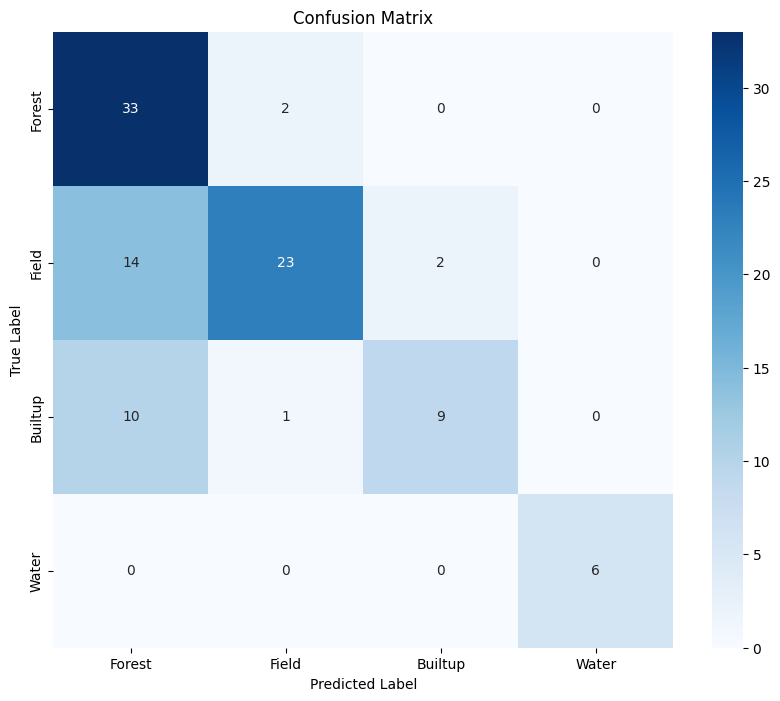

Overall Accuracy: 0.71

Classification Metrics:
         Precision    Recall  F1 Score
Forest    0.578947  0.942857  0.717391
Field     0.884615  0.589744  0.707692
Builtup   0.818182  0.450000  0.580645
Water     1.000000  1.000000  1.000000


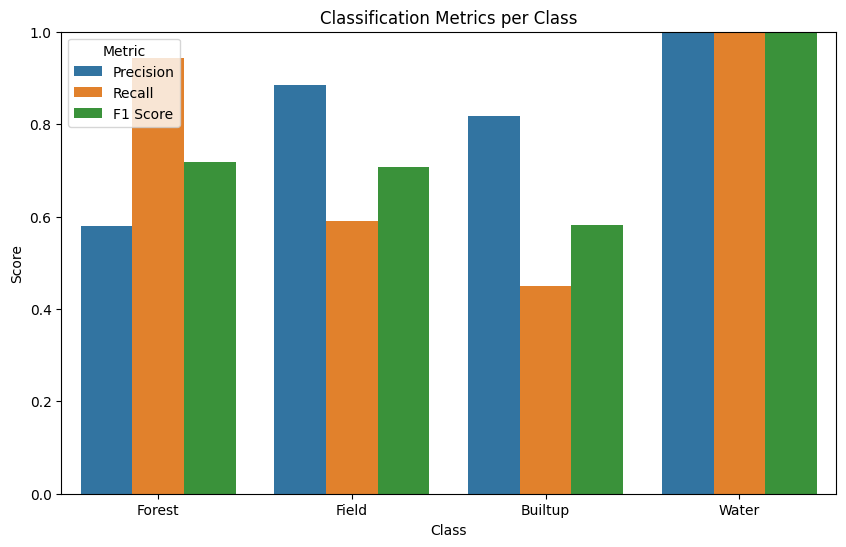

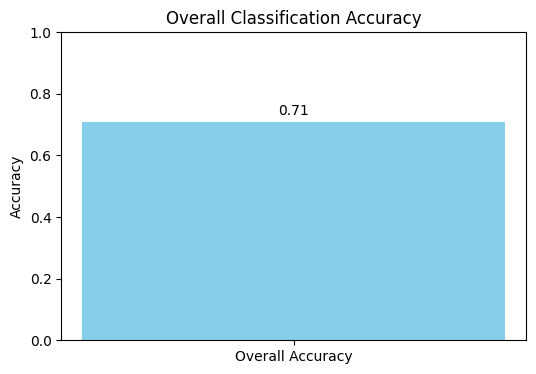

In [20]:
# Load your classified GeoDataFrame (already done as classified_gdf)
groundtruth_fc = ee.FeatureCollection('projects/ee-thesiswar/assets/assesspoints')
groundtruth_gdf = convert_to_geopandas(groundtruth_fc)

joined = gpd.sjoin(classified_gdf, groundtruth_gdf, how='inner', op='intersects')
y_true = joined['GrndTruth']
y_pred = joined['class_code']

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred))

import matplotlib.pyplot as plt

# Define class labels
class_labels = ['Forest', 'Field', 'Builtup', 'Water']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Calculate User's Accuracy (Precision) and Producer's Accuracy (Recall)
precision = cm_df.values.diagonal() / cm_df.sum(axis=0)
recall = cm_df.values.diagonal() / cm_df.sum(axis=1)

# Calculate Overall Accuracy
overall_accuracy = cm.trace() / cm.sum()

# Calculate F1 Scores
f1_scores = 2 * (precision * recall) / (precision + recall)

# Add accuracy metrics to the DataFrame
cm_df.loc['Precision'] = precision
cm_df['Recall'] = recall
cm_df.loc['F1 Score'] = f1_scores

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df.iloc[:-2, :-1], annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display Overall Accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Display Precision, Recall, and F1 Scores
accuracy_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores
}, index=class_labels)

print("\nClassification Metrics:")
print(accuracy_df)
# ...existing code...
# Reset index to turn the index into a column
accuracy_df_reset = accuracy_df.reset_index().rename(columns={'index': 'Class'})

# Melt the DataFrame for seaborn
accuracy_melted = accuracy_df_reset.melt(id_vars='Class', 
                              value_vars=['Precision', 'Recall', 'F1 Score'], 
                              var_name='Metric', 
                              value_name='Score')

# Plot the metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_melted, x='Class', y='Score', hue='Metric')
plt.title('Classification Metrics per Class')
plt.ylim(0, 1)
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

# Plot Overall Accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Overall Accuracy'], [overall_accuracy], color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Overall Classification Accuracy')
plt.text(0, overall_accuracy + 0.02, f"{overall_accuracy:.2f}", ha='center')
plt.show()


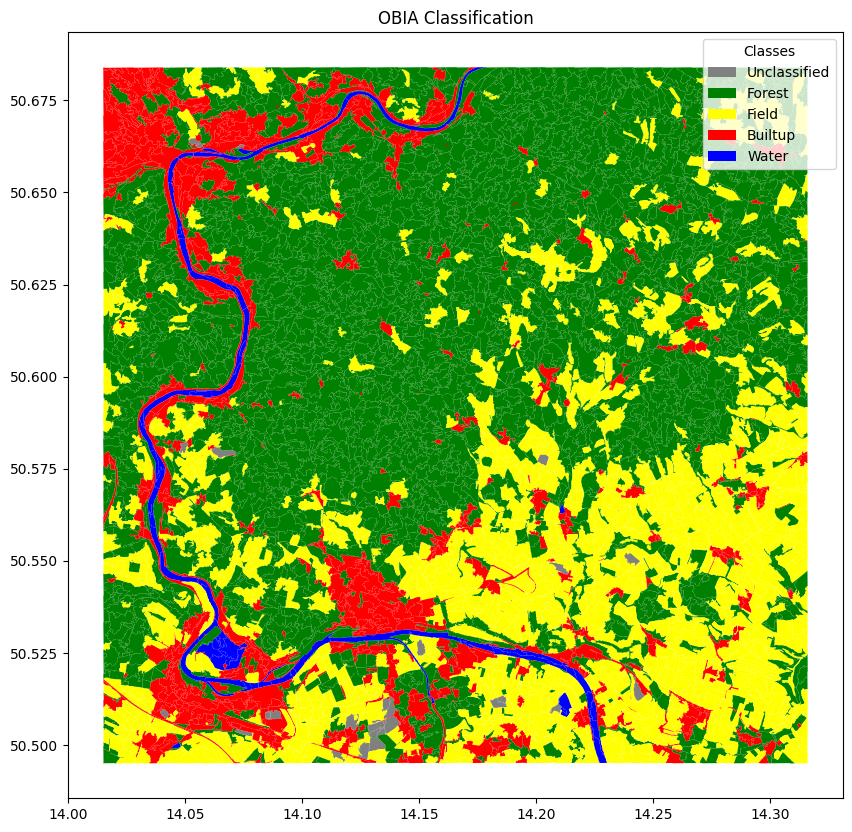

In [81]:

# Define color dictionary based on class_code
color_dict = {
    0: "#808080",  # Gray - Unclassified
    1: "#008000",  # Forest - Green
    2: "#FFFF00",  # Field - Yellow
    3: "#FF0000",  # Builtup - Red
    5: "#0000FF",  # Water - Blue
}

# Map colors to the GeoDataFrame
classified_gdf['color'] = classified_gdf['class_code'].map(color_dict).fillna("#000000")  # Default to Black

# Plot using matplotlib with predefined colors
if classified_gdf is not None:
    fig, ax = plt.subplots(figsize=(10, 10))
    classified_gdf.plot(color=classified_gdf['color'], ax=ax)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor="#808080", label="Unclassified"),
        Patch(facecolor="#008000", label="Forest"),
        Patch(facecolor="#FFFF00", label="Field"),
        Patch(facecolor="#FF0000", label="Builtup"),
        Patch(facecolor="#0000FF", label="Water"),
    ]
    ax.legend(handles=legend_elements, title="Classes")
    
    plt.title('OBIA Classification')
    plt.show()



In [70]:

# -----------------------------------
# 9. Style Polygons by 'class_code'
# -----------------------------------
def style_polygons(gdf):
    """Applies styling to polygons based on their class_code."""
    color_dict = {
        0: "#808080",  # Gray - Unclassified
        1: "#008000",  # Forest - Green
        2: "#FFFF00",  # Field - Yellow
        3: "#FF0000",  # Builtup - Red
        4: "#8B4513",  # Shrubs - Brown
        5: "#0000FF",  # Water - Blue
    }
    
    # Create a color column based on class_code
    gdf['color'] = gdf['class_code'].map(color_dict).fillna("#000000")  # Default to Black if undefined
    
    return gdf

if classified_gdf is not None:
    classified_gdf = style_polygons(classified_gdf)

# -----------------------------------
# 10. Add Layers Directly to geemap.Map
# -----------------------------------
# Initialize the Map
Map = geemap.Map()
Map.centerObject(aoi, 13)
Map.add_basemap("SATELLITE")

# Add Classified Polygons if available
if classified_gdf is not None:
    # Define a style function for GeoPandas
    def get_style(feature):
        # Use "properties" to access attribute columns
        return {
            "color": feature["properties"]["color"],
            "weight": 2,
            "fillColor": feature["properties"]["color"] + "100"  # Semi-transparent fill
        }
    
    # Apply the style function correctly using style_callback
    Map.add_gdf(
        classified_gdf,
        layer_name="Classified SNIC",
        style_callback=get_style
    )

# -----------------------------------
# 11. Display the Map
# -----------------------------------
# Display the map
Map


Map(center=[50.58005879957319, 14.15047271077684], controls=(WidgetControl(options=['position', 'transparent_b…